In [1]:
import os
import json
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import (Input, TimeDistributed, GlobalAveragePooling2D,
                                     Bidirectional, LSTM, Dense, Dropout, BatchNormalization)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

2025-05-25 17:06:47.789696: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-25 17:06:47.804061: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748173007.821506    8876 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748173007.826739    8876 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748173007.839413    8876 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
# Paths and constants
data_path = "/mnt/d/Group50/Facial_Emotion_Recongnition/Datasets/VideoDataset2" 
OUTPUT_PATH = "processed_videos"
MAX_FRAMES = 30
IMG_SIZE = (64, 64)
BATCH_SIZE = 8

In [3]:
# Load metadata
with open(os.path.join(OUTPUT_PATH, "metadata_encoded.json"), "r") as f:
    metadata = json.load(f)

In [4]:
# Label info
labels = [item["label"] for item in metadata]
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels)
num_classes = len(label_encoder.classes_)

# Assign encoded labels
for i, item in enumerate(metadata):
    item["label_encoded"] = int(y_encoded[i])

In [5]:
# Train/val split
train_meta, val_meta = train_test_split(metadata, test_size=0.2, random_state=42)


In [7]:
# Data Generator
class VideoDataGenerator(Sequence):
    def __init__(self, metadata, batch_size, num_classes, data_path, shuffle=True):
        self.metadata = metadata
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.data_path = data_path
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.metadata) / self.batch_size))

    def __getitem__(self, index):
        batch_metadata = self.metadata[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__data_generation(batch_metadata)
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.metadata)

    def __data_generation(self, batch_metadata):
        X = []
        y = []
        for item in batch_metadata:
            frames = np.load(os.path.join(self.data_path, f"{item['video_id']}.npy"))
            X.append(frames)
            y.append(item["label_encoded"])
        return np.array(X), to_categorical(y, num_classes=self.num_classes)


In [8]:
# Create generators
train_gen = VideoDataGenerator(train_meta, BATCH_SIZE, num_classes, OUTPUT_PATH)
val_gen = VideoDataGenerator(val_meta, BATCH_SIZE, num_classes, OUTPUT_PATH)


In [9]:
# Build model
base_cnn = MobileNetV2(include_top=False, weights='imagenet', input_shape=(64, 64, 3))
base_cnn.trainable = False  # Freeze CNN for now

input_layer = Input(shape=(MAX_FRAMES, IMG_SIZE[1], IMG_SIZE[0], 3))
x = TimeDistributed(base_cnn)(input_layer)
x = TimeDistributed(GlobalAveragePooling2D())(x)
x = TimeDistributed(BatchNormalization())(x)
x = Dropout(0.3)(x)

x = Bidirectional(LSTM(128, dropout=0.3, return_sequences=False))(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/tmp/ipykernel_8876/178174543.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_cnn = MobileNetV2(include_top=False, weights='imagenet', input_shape=(64, 64, 3))
I0000 00:00:1748173059.611761    8876 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13512 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080, pci bus id: 0000:01:00.0, compute capability: 8.9


In [10]:

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

In [11]:
# Train model
history = model.fit(train_gen, validation_data=val_gen, epochs=10, callbacks=callbacks)


/home/group50/anaconda3/envs/condaenv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1748173170.891794    9186 cuda_dnn.cc:529] Loaded cuDNN version 90300


1029/1029 ━━━━━━━━━━━━━━━━━━━━ 651s 559ms/step - accuracy: 0.3114 - loss: 1.6735 - val_accuracy: 0.5085 - val_loss: 1.3055 - learning_rate: 0.0010
Epoch 2/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 551s 535ms/step - accuracy: 0.5033 - loss: 1.2979 - val_accuracy: 0.6125 - val_loss: 1.0622 - learning_rate: 0.0010
Epoch 3/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 554s 538ms/step - accuracy: 0.5935 - loss: 1.0844 - val_accuracy: 0.6650 - val_loss: 0.9244 - learning_rate: 0.0010
Epoch 4/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 556s 541ms/step - accuracy: 0.6611 - loss: 0.8969 - val_accuracy: 0.7103 - val_loss: 0.8067 - learning_rate: 0.0010
Epoch 5/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 555s 539ms/step - accuracy: 0.6930 - loss: 0.8388 - val_accuracy: 0.7224 - val_loss: 0.7937 - learning_rate: 0.0010
Epoch 6/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 556s 540ms/step - accuracy: 0.7170 - loss: 0.7760 - val_accuracy: 0.7501 - val_loss: 0.7197 - learning_rate: 0.0010
Epoch 7/10
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 559s 543ms/step - acc

# Save
model.save("cnn_Bilstm_model.h5")
print("✅ Model trained and saved!")

✅ Model trained and saved!


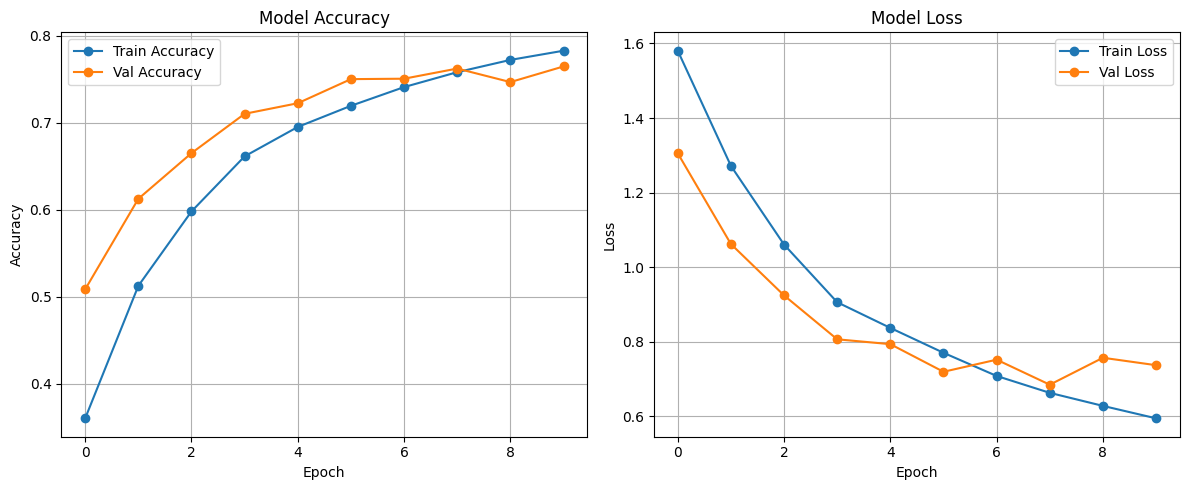

: 

In [ ]:
# Save
model.save("cnn_Bilstm_model2.h5")
print("✅ Model trained and saved!")
# Plot Accuracy and Loss
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# Plot Accuracy and Loss
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
